In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# def _node_get(node: torch._C.Node, key: str):
#     """Gets attributes of a node which is polymorphic over return type."""
#     sel = node.kindOf(key)
#     return getattr(node, sel)(key)

# torch._C.Node.__getitem__ = _node_get

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("../../weird_dj.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a polar bear", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.505 0.331 0.164]]


In [4]:
type(image_features)

torch.Tensor

In [5]:
image_features.shape

torch.Size([1, 512])

In [8]:
logits_per_text.shape

torch.Size([3, 1])

In [6]:
text_features.shape

torch.Size([3, 512])

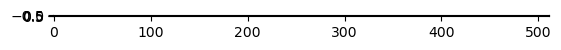

In [11]:
plt.imshow(image_features.cpu())

In [25]:
dim = int(image_features.numel() ** 0.5)
image_relevance = image_features[:, :484].reshape(1, 1, dim, dim)
image_relevance = torch.nn.functional.interpolate(image_relevance, size=64, mode='bilinear')
image_relevance = image_relevance.reshape(64, 64).cuda().data.cpu().numpy()
image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

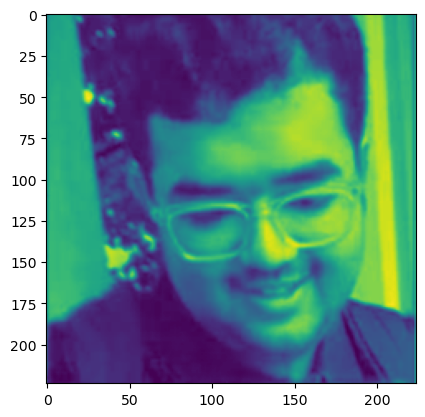

In [26]:
plt.imshow(image[0][0].cpu())


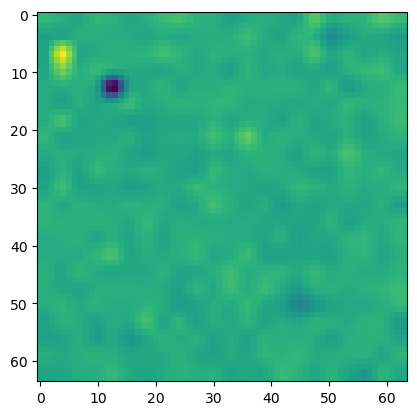

In [27]:
plt.imshow(image_relevance)